# Random Forest

#### Index<a name="index"></a>
1. [Import packages](#imports)
2. [Load data](#loadData)
3. [Set up classifier data](#setupData)

## 1. Import packages<a name="imports"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Aestetic settings

In [3]:
%matplotlib inline

sns.set(font_scale=1.3, style="ticks")

## 2. Load data<a name="loadData"></a>

In [3]:
number_clusters = 1229

In [4]:
true_clusters_2d_hist_file = f'/content/drive/MyDrive/Random-forest-open-cluster-master/data/true_clusters_2d_hist_{number_clusters}.npy'
true_clusters_2d_hist = np.load(true_clusters_2d_hist_file, allow_pickle=True)

false_clusters_2d_hist_file = f'/content/drive/MyDrive/Random-forest-open-cluster-master/data/non_clusters_2d_hist.npy'
false_clusters_2d_hist = np.load(false_clusters_2d_hist_file, allow_pickle=True)

val_clusters_2d_hist_file = f'/content/drive/MyDrive/Random-forest-open-cluster-master/data/matrix_false_nonclusters.npy'
val_clusters_2d_hist = np.load(val_clusters_2d_hist_file, allow_pickle=True)

In [5]:
print(np.shape(true_clusters_2d_hist))
print(np.shape(false_clusters_2d_hist))
print(np.shape(val_clusters_2d_hist))

(1229, 400)
(1300, 400)
(32, 400)


## 3. Set up classifier data<a name="setupData"></a>

In [71]:
all_clusters = np.concatenate((true_clusters_2d_hist, 
                               false_clusters_2d_hist))
true_labels = np.concatenate((np.ones_like(true_clusters_2d_hist[:, 0]), 
                              np.zeros_like(false_clusters_2d_hist[:, 0])))

In [72]:
x_train, x_test, y_train, y_test = train_test_split(all_clusters, true_labels,test_size=0.3, random_state=2)

In [8]:
np.shape(x_train)

(1770, 400)

## 4. Classification<a name="classification"></a>

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see:
                  http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm = cm, 
                           normalize = True, # show proportions
                          target_names = y_labels_vals, # list of classes names
                          title = best_estimator_name) # title of graph
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.8f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Parameter adjustment


In [73]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9670619235836627
[[385  22]
 [  3 349]]


In [74]:
param_test1 = {"n_estimators":range(30,100,5)}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(random_state=2),param_grid=param_test1,
                        scoring='roc_auc',cv=5)
gsearch1.fit(x_train,y_train)

print(gsearch1.best_params_)
print("best accuracy:%f" % gsearch1.best_score_)

{'n_estimators': 90}
best accuracy:0.997188


In [75]:
param_test2 = {'max_depth':range(10,100,10), 'min_samples_split':range(2,10,2)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 75,oob_score=True, random_state=2),
   param_grid = param_test2, scoring='roc_auc', cv=5)
gsearch2.fit(x_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 10, 'min_samples_split': 6}, 0.9970376805574691)

In [76]:
param_test3 = {'min_samples_split':range(5,15,2), 'min_samples_leaf':range(2,11,1)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 75, max_depth=20,
                                  oob_score=True, random_state=2),
   param_grid = param_test3, scoring='roc_auc', cv=5)
gsearch3.fit(x_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 2, 'min_samples_split': 5}, 0.9969323379761912)

In [85]:
#clf= RandomForestClassifier(random_state=0)

clf= RandomForestClassifier(n_estimators= 75, max_depth=20, min_samples_split=6, min_samples_leaf=1,max_features='auto',random_state=0)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
pred = clf.predict(val_clusters_2d_hist)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9696969696969697
[[386  21]
 [  2 350]]


In [84]:
pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

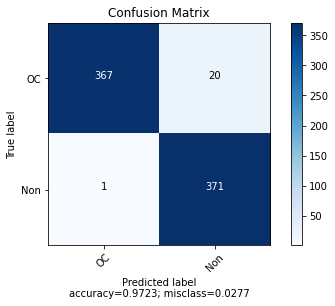

In [67]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,target_names=['OC','Non'], title='Confusion Matrix', cmap=None, normalize= False)
#plot_confusion_matrix(y_test, y_pred, 'Confusion matrix',[1,0])

Go to [Index](#index)